In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams["text.usetex"] = True

<IPython.core.display.Javascript object>

# Data

In [3]:
N = 25
X_d = np.reshape(np.linspace(0, 0.9, N), (N, 1))
Y_d = np.cos(10 * X_d ** 2) + 0.1 * np.sin(100 * X_d)

<IPython.core.display.Javascript object>

In [4]:
def poly(x, j):
    return x ** j


v_poly = np.vectorize(poly)

<IPython.core.display.Javascript object>

In [5]:
def trig(x, j):
    if not isinstance(x, float):
        x = x[0]

    toret = []
    for k in range(1, j + 1):
        toret.append(np.sin(2 * np.pi * k * x))
        toret.append(np.cos(2 * np.pi * k * x))
    return np.array([1] + toret)

<IPython.core.display.Javascript object>

## get mle

In [6]:
def gauss(x, u, sig):
    return np.exp(-(x - u) ** 2 / (2 * sig ** 2))


def gauss_unbiased(x, u, sig):
    if not isinstance(x, float):
        x = x[0]

    if not isinstance(sig, float):
        sig = sig[0]

    toret = []
    for k in u:
        toret.append(np.exp(-(x - k) ** 2 / (2 * sig ** 2)))
    return np.array([1] + toret)


v_gauss = np.vectorize(gauss)

<IPython.core.display.Javascript object>

In [7]:
def get_phi(x, v_func, *argv):
    return np.matrix([v_func(k, *argv) for k in x])


def w_pred(x, y, v_func, *argv):
    phi = get_phi(x, v_func, *argv)
    return np.linalg.inv(phi.T * phi) * phi.T * y

<IPython.core.display.Javascript object>

In [8]:
def get_pred(minn, maxx, v_func, *argv):
    w = w_pred(X_d, Y_d, v_func, *argv)
    x = np.linspace(minn, maxx, 200)
    phi = get_phi(x, v_func, *argv)
    y = phi * w
    return x, y

<IPython.core.display.Javascript object>

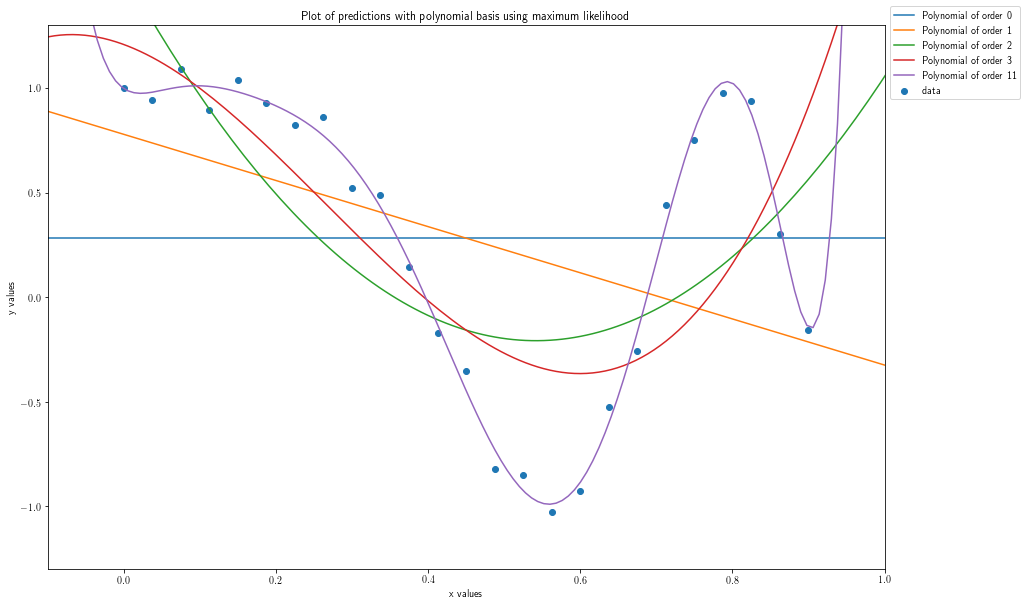

<IPython.core.display.Javascript object>

In [9]:
# Plot Poly
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 1, 1)
ax1.scatter(X_d, Y_d, label="data")

for k in [0, 1, 2, 3, 11]:
    x, y = get_pred(-0.3, 1.3, v_poly, list(range(k + 1)))
    ax1.plot(x, y, label=f"Polynomial of order {k}")


ax1.set_xlim(-0.1, 1.0)
ax1.set_ylim(-1.3, 1.3)
ax1.set_xlabel("x values")
ax1.set_ylabel("y values")
ax1.set_title("Plot of predictions with polynomial basis using maximum likelihood")
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.95))
plt.savefig("./template/mle_diff_basis")

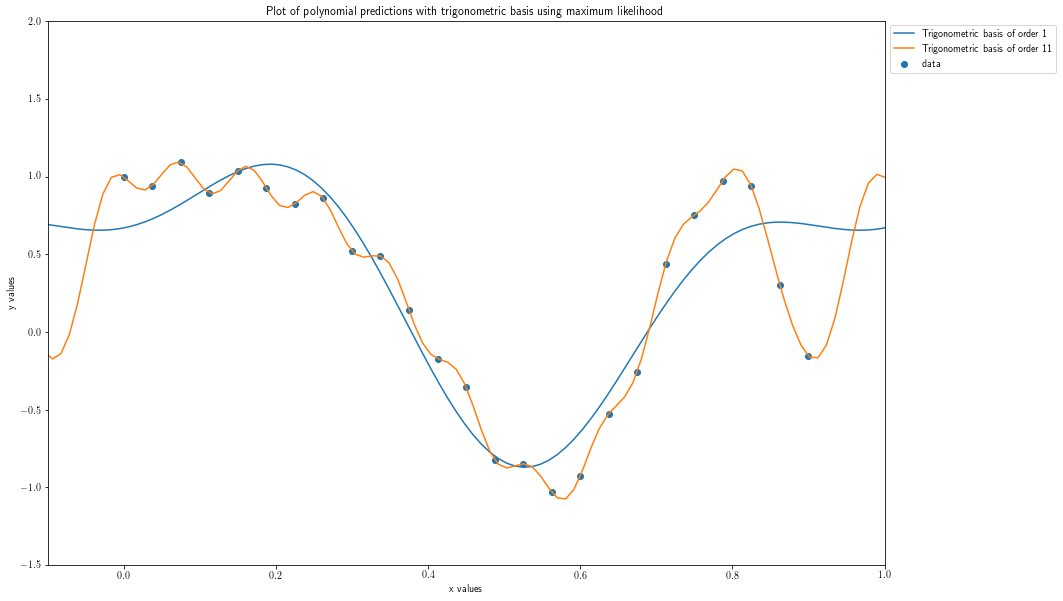

<IPython.core.display.Javascript object>

In [10]:
# Plot trig
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 1, 1)
ax1.scatter(X_d, Y_d, label="data")

for k in [1, 11]:
    x, y = get_pred(-1, 1.2, trig, k + 1)
    ax1.plot(x, y, label=f"Trigonometric basis of order {k}")


ax1.set_xlim(-0.1, 1.0)
ax1.set_ylim(-1.5, 2)
ax1.set_xlabel("x values")
ax1.set_ylabel("y values")
ax1.set_title(
    "Plot of polynomial predictions with trigonometric basis using maximum likelihood"
)
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.95))
plt.savefig("./template/mle_diff_trig_basis")

# LOO CV

In [11]:
def get_test_train(k):
    x_train = X_d[X_d != X_d[k]]
    x_test = X_d[k]
    y_train = Y_d[Y_d != Y_d[k]]
    y_test = Y_d[k]
    return (
        np.reshape(x_train, (len(x_train), 1)),
        np.reshape(x_test, (len(x_test), 1)),
        np.reshape(y_train, (len(y_train), 1)),
        np.reshape(y_test, (len(y_test), 1)),
    )

<IPython.core.display.Javascript object>

In [12]:
class Model:
    def __init__(self, X, Y, v_func, *argv):
        self.v_func = v_func
        self.argv = argv
        self.X = X
        self.Y = Y
        self.error_test = []
        self.error_train = []

        for k in range(len(X)):
            x_tr, x_te, y_tr, y_te = get_test_train(k)
            self.set_error(x_tr, x_te, y_tr, y_te)

    def set_error(self, x_train, x_test, y_train, y_test):
        w = w_pred(x_train, y_train, self.v_func, *self.argv)
        self.get_error_test(x_test, y_test, w)
        self.get_error_train(x_train, y_train, w)

    def fit(self, x, w):
        phi = get_phi(x, self.v_func, *self.argv)
        y = phi * w
        return y

    def get_error_test(self, x_test, y_test, w):
        y_pred = float(self.fit(x_test, w))
        self.error_test.append(((y_pred - float(y_test)) ** 2))

    def get_error_train(self, x_train, y_train, w):
        y_pred = self.fit(x_train, w)
        self.error_train.append(np.mean((np.asarray(y_train - y_pred) ** 2)))

<IPython.core.display.Javascript object>

In [13]:
errors_test = []
errors_train = []
for k in range(11):
    lm = Model(X_d, Y_d, trig, k)
    errors_test.append(np.mean(lm.error_test))
    errors_train.append(np.mean(lm.error_train))

<IPython.core.display.Javascript object>

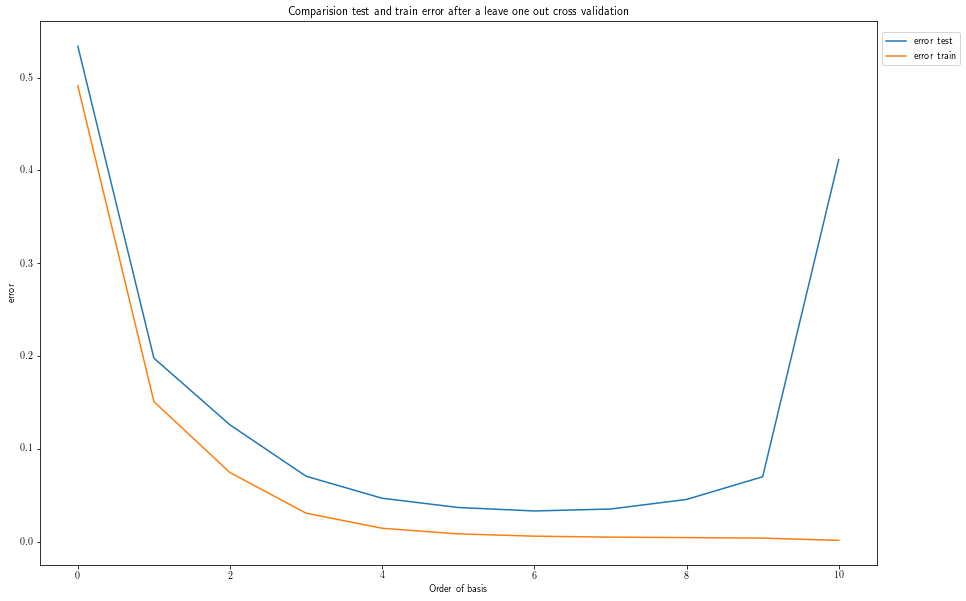

<IPython.core.display.Javascript object>

In [14]:
# Plot trig
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 1, 1)
x = list(range(11))
ax1.plot(x, errors_test, label="error test")
ax1.plot(x, errors_train, label="error train")
ax1.set_xlabel("Order of basis")
ax1.set_ylabel("error")
ax1.set_title("Comparision test and train error after a leave one out cross validation")
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.95))
plt.savefig("./template/cv_error")

# Question 2

## a

In [15]:
def lml(alpha, beta, Phi, Y):
    C = alpha * Phi * Phi.T + beta * np.identity(N)
    return (
        -1
        / 2
        * (
            N * np.log(2 * np.pi)
            + np.log(np.linalg.det(C))
            + (Y.T * np.linalg.inv(C) * Y)
        )
    )


def grad_lml(alpha, beta, Phi, Y):
    C = alpha * Phi * Phi.T + beta * np.identity(N)
    d_1 = -(
        1 / 2 * np.trace(np.linalg.inv(C) * Phi * Phi.T)
        - 1 / 2 * Y.T * np.linalg.inv(C) * Phi * Phi.T * np.linalg.inv(C) * Y
    )
    d_2 = -(
        1 / 2 * np.trace(np.linalg.inv(C))
        - 1 / 2 * Y.T * np.linalg.inv(C) * np.linalg.inv(C) * Y
    )
    return np.asmatrix([float(d_1), float(d_2)])

<IPython.core.display.Javascript object>

In [16]:
def grad_desc(grad, step, e, start, *argv):
    mn = np.asmatrix(start)
    record = [np.copy(mn)]
    for _ in range(step):
        mn += e * grad(mn[0, 0], mn[0, 1], *argv)
        if mn[0, 1] < 0:
            mn[0, 1] = record[-1][0, 1]
            e /= 100
        record.append(np.copy(mn))
    return mn, record

<IPython.core.display.Javascript object>

## b

In [17]:
st = [0.5, 0.57]
learning_rate = 0.01
mph = get_phi(X_d, v_poly, list(range(2)))


gdsesc = grad_desc(grad_lml, 2000, learning_rate, st, mph, Y_d)
last_point = (gdsesc[0][0, 0], gdsesc[0][0, 1])
gdsesc = list(map(lambda l: (l[0, 0], l[0, 1]), gdsesc[1]))

<IPython.core.display.Javascript object>

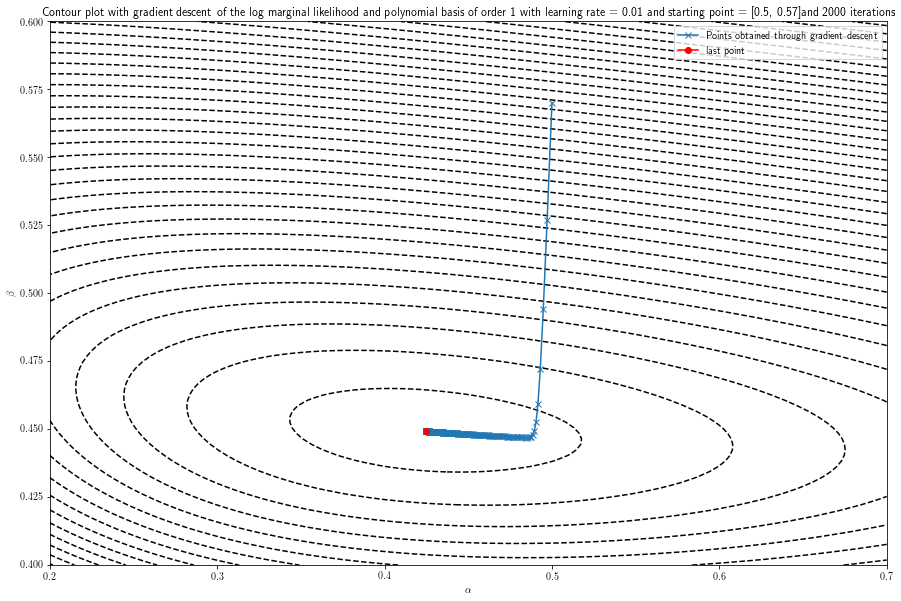

<IPython.core.display.Javascript object>

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))
alpha = np.linspace(0.2, 0.7, 100)
beta = np.linspace(0.4, 0.6, 100)
Alpha, Beta = np.meshgrid(alpha, beta)

Z = [[[a, b] for a in alpha] for b in beta]
results = np.asarray(
    list(
        map(
            lambda l: np.asarray(
                list(map(lambda v: np.double(lml(v[0], v[1], mph, Y_d)), l))
            ),
            Z,
        )
    )
)
ax.plot(*zip(*gdsesc), marker="x", label="Points obtained through gradient descent")
ax.plot(last_point[0], last_point[1], marker="o", color="red", label="last point")


plt.contour(Alpha, Beta, results, 50, colors="black")
ax.set_xlabel(r"\textbf{$\alpha$}")
ax.set_ylabel(r"\textbf{$\beta$}")
ax.set_title(
    (
        f"Contour plot with gradient descent of the log marginal "
        f"likelihood and polynomial basis of order 1 "
        f"with learning rate = {learning_rate} and starting point = {st}and 2000 iterations"
    )
)
ax.legend()
plt.savefig("./template/grad_b")
plt.show()

In [19]:
print(last_point)

(0.4245548251649705, 0.44923133732278037)


<IPython.core.display.Javascript object>

## Question c

In [20]:
st = [0.1, 0.1]
learning_rate = 0.00001
mph = get_phi(X_d, trig, 0)


gdsesc = grad_desc(grad_lml, 20000, learning_rate, st, mph, Y_d)
last_point = (gdsesc[0][0, 0], gdsesc[0][0, 1])
gdsesc = list(map(lambda l: (l[0, 0], l[0, 1]), gdsesc[1]))

fig, ax = plt.subplots(figsize=(15, 10))
alpha = np.linspace(0.01, 0.2, 100)
beta = np.linspace(0.45, 0.6, 100)
Alpha, Beta = np.meshgrid(alpha, beta)

Z = [[[a, b] for a in alpha] for b in beta]
results = np.asarray(
    list(
        map(
            lambda l: np.asarray(
                list(map(lambda v: np.double(lml(v[0], v[1], mph, Y_d)), l))
            ),
            Z,
        )
    )
)
ax.plot(*zip(*gdsesc), marker="x", label="Points obtained through gradient descent")
ax.plot(last_point[0], last_point[1], marker="o", color="red", label="last point")


plt.contour(Alpha, Beta, results, 50, colors="black")
ax.set_xlabel(r"\textbf{$\alpha$}")
ax.set_ylabel(r"\textbf{$\beta$}")
ax.set_title(
    (
        f"Contour plot with gradient descent of the log marginal "
        f"likelihood and a trignometric basis of order 5 "
        f"with learning rate = {learning_rate} and starting point = {st} and 20000 iterations"
    )
)
ax.legend()
ax.set_ylim(0.45, 0.6)
plt.savefig("./template/grad_deg0")
plt.show()

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [ ]:
st = [0.1, 0.1]
learning_rate = 0.00001
mph = get_phi(X_d, trig, 11)


gdsesc = grad_desc(grad_lml, 20000, learning_rate, st, mph, Y_d)
last_point = (gdsesc[0][0, 0], gdsesc[0][0, 1])
gdsesc = list(map(lambda l: (l[0, 0], l[0, 1]), gdsesc[1]))

fig, ax = plt.subplots(figsize=(15, 10))
alpha = np.linspace(0.01, 0.2, 100)
beta = np.linspace(0.0001, 0.02, 100)
Alpha, Beta = np.meshgrid(alpha, beta)

Z = [[[a, b] for a in alpha] for b in beta]
results = np.asarray(
    list(
        map(
            lambda l: np.asarray(
                list(map(lambda v: np.double(lml(v[0], v[1], mph, Y_d)), l))
            ),
            Z,
        )
    )
)
ax.plot(*zip(*gdsesc), marker="x", label="Points obtained through gradient descent")
ax.plot(last_point[0], last_point[1], marker="o", color="red", label="last point")


plt.contour(Alpha, Beta, results, 50, colors="black")
ax.set_xlabel(r"\textbf{$\alpha$}")
ax.set_ylabel(r"\textbf{$\beta$}")
ax.set_title(
    (
        f"Contour plot with gradient descent of the log marginal "
        f"likelihood and a trignometric basis of order 5 "
        f"with learning rate = {learning_rate} and starting point = {st} and 20000 iterations "
    )
)
ax.legend()
ax.set_ylim(0.00, 0.02)
plt.savefig("./template/grad_deg1")
plt.show()

In [ ]:
lml(-0.34048581, 9.6077154, get_phi(X_d, trig, 11), Y_d)

In [ ]:
last_point

# Getting the values of alpha and beta

In [ ]:
st = [0.1, 0.1]
learning_rate = 0.00001
alpha_beta = []

for k in range(13):
    mph = get_phi(X_d, trig, k)
    gdsesc = grad_desc(grad_lml, 20000, learning_rate, st, mph, Y_d)
    last_point = (gdsesc[0][0, 0], gdsesc[0][0, 1])
    alpha_beta.append(last_point)

In [ ]:
max_like = []
for k in range(len(alpha_beta)):
    tmp_phi = get_phi(X_d, trig, k)
    max_like.append(float(lml(alpha_beta[k][0], alpha_beta[k][1], tmp_phi, Y_d)))

In [ ]:
# Plot trig
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 1, 1)
x = list(range(13))
ax1.plot(x, max_like, "b-", marker="o", label="MLE accoridng to basis")
ax1.set_xlabel("Order")
ax1.set_ylabel("MLE")
ax1.set_title("Log marginal likelihood according to the order")
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.95))
plt.savefig("./template/comparison")

## Question d

In [21]:
alpha = 1
beta = 0.1

<IPython.core.display.Javascript object>

In [34]:
def posterior(alpha, beta, Phi, Y):
    Sn = np.linalg.inv(
        (1 / alpha * np.identity(Phi.T.shape[0]) + 1 / beta * Phi.T * Phi)
    )
    mn = 1 / beta * Sn * Phi.T * Y

    return Sn, mn

<IPython.core.display.Javascript object>

In [64]:
def get_weight(alpha, beta, Phi, Y):
    Sn, mn = posterior(alpha, beta, Phi, Y)
    return np.random.multivariate_normal(np.array(tn.T)[0, :], Sn)

<IPython.core.display.Javascript object>

In [23]:
def ret_sample(m, x, v_gauss=v_gauss):
    return get_phi(x, v_gauss, means, scale) * m

<IPython.core.display.Javascript object>

In [24]:
def ret_var(S, x, v_gauss=v_gauss):
    ph = get_phi(x, v_gauss, means, scale)
    return ph * S * ph.T

<IPython.core.display.Javascript object>

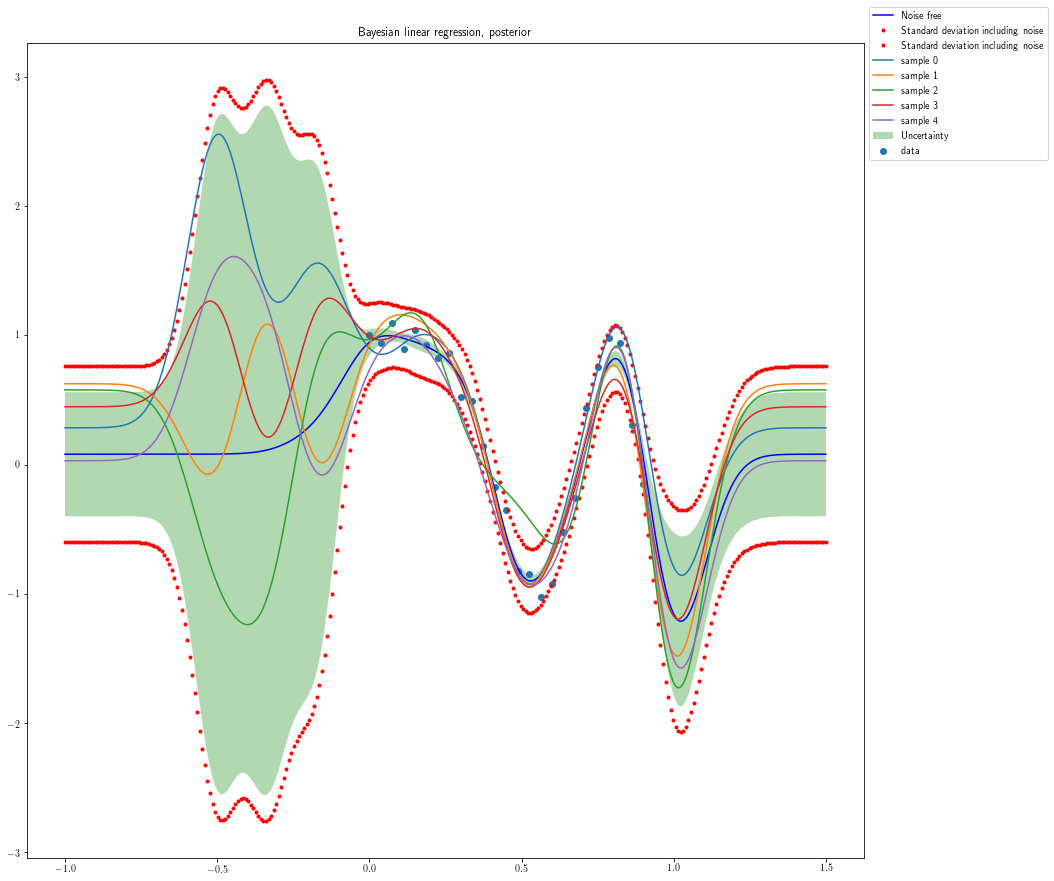

<IPython.core.display.Javascript object>

In [102]:
# Take 5 samples to compute posterior
x_samples = X_d
y_samples = Y_d
means = np.linspace(-0.5, 1, 10)
scale = [0.1 for k in range(10)]
g_phi = get_phi(x_samples, gauss_unbiased, means, scale)
S, m = posterior(alpha, beta, g_phi, y_samples)

fig = plt.figure(figsize=(15, 15))
points = 300
ax1 = plt.subplot(1, 1, 1)


noise_free = []
unc_b = []

for k in np.linspace(-1, 1.5, points):
    noise_free.append(ret_sample(m, [k], v_gauss=gauss_unbiased)[0, 0])
    unc_b.append(ret_var(S, [k], v_gauss=gauss_unbiased)[0, 0])

noise_free = np.array(noise_free)
unc_b = np.array(unc_b)

unc_up = noise_free + 2 * unc_b
unc_down = noise_free - 2 * unc_b
x = np.linspace(-1, 1.5, points)

ax1.plot(x, noise_free, "b-", label="Noise free")
# ax1.plot(x, unc_up, "g-", label="Uncertainty up")
# ax1.plot(x, unc_down, "g-", label="Uncertainty down")
ax1.plot(x, unc_up + 2 * beta, "r.", label="Standard deviation including noise")
ax1.plot(x, unc_down - 2 * beta, "r.", label="Standard deviation including noise")

ax1.fill_between(
    x,
    unc_up,
    unc_down,
    where=unc_up >= unc_down,
    facecolor="green",
    interpolate=False,
    alpha=0.3,
    label="Uncertainty",
)
ax1.fill_between(
    x,
    unc_up,
    unc_down,
    where=unc_up <= unc_down,
    facecolor="green",
    interpolate=False,
    alpha=0.3,
)

g_phi = get_phi(X_d, gauss_unbiased, means, scale)
ts, tn = posterior(alpha, beta, g_phi, Y_d)

for j in range(5):
    w = get_weight(alpha, beta, g_phi, Y_d)
    tmp = []
    for k in np.linspace(-1, 1.5, points):
        tmp.append(ret_sample(np.matrix(w).T, [k], v_gauss=gauss_unbiased)[0, 0])
    ax1.plot(x, tmp, label=f"sample {j}")

ax1.scatter(X_d, Y_d, label="data")
ax1.set_title("Bayesian linear regression, posterior")
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.95))
plt.savefig("./template/baysian_biased")

In [70]:
g_phi = get_phi(X_d[0], gauss_unbiased, means, scale)
ts, tn = posterior(alpha, beta, g_phi, Y_d[0])
get_weight(alpha, beta, g_phi, Y_d[0])

array([ 0.85227676, -1.41150686,  0.35037003,  0.24502046,  0.12961818,
       -0.25941988,  1.55303124,  0.41393399, -1.39737945,  0.18604917,
       -0.25184073])

<IPython.core.display.Javascript object>

With other samples

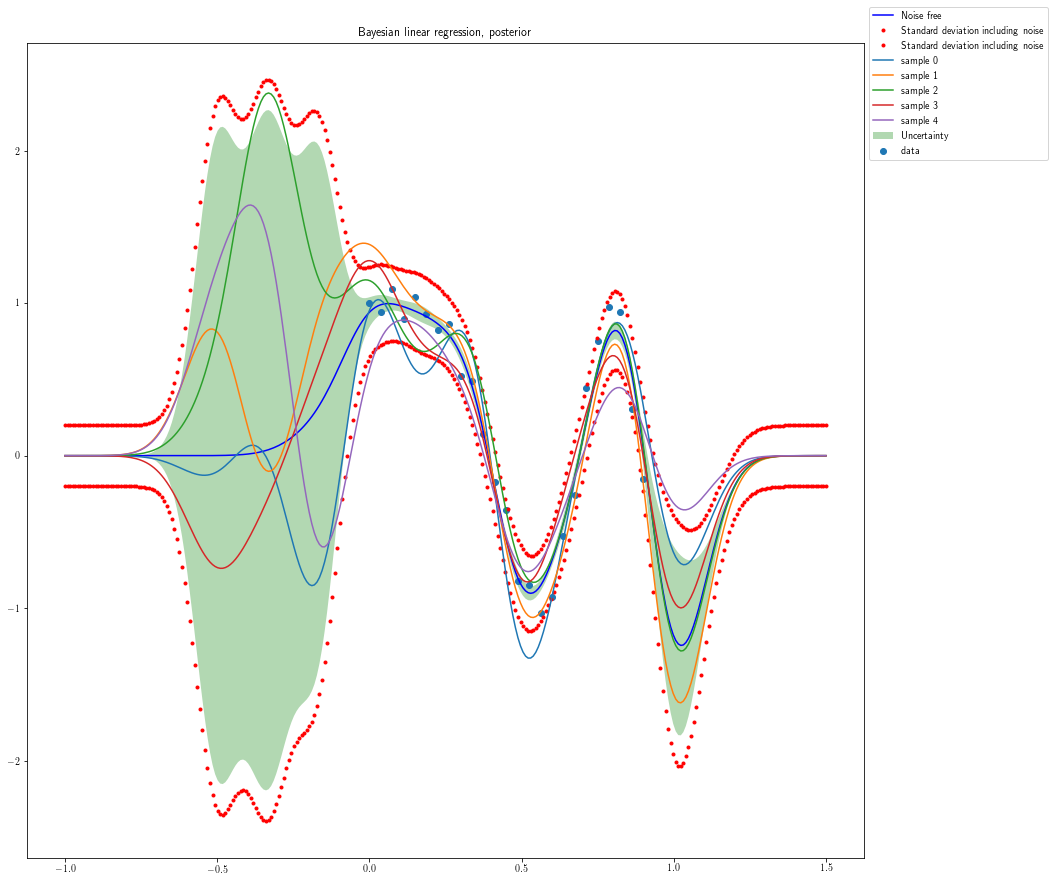

<IPython.core.display.Javascript object>

In [105]:
# Take 5 samples to compute posterior
x_samples = X_d
y_samples = Y_d
means = np.linspace(-0.5, 1, 10)
scale = [0.1 for k in range(10)]
g_phi = get_phi(x_samples, v_gauss, means, scale)
S, m = posterior(alpha, beta, g_phi, y_samples)

fig = plt.figure(figsize=(15, 15))
points = 300
ax1 = plt.subplot(1, 1, 1)


noise_free = []
unc_b = []

for k in np.linspace(-1, 1.5, points):
    noise_free.append(ret_sample(m, [k], v_gauss=v_gauss)[0, 0])
    unc_b.append(ret_var(S, [k], v_gauss=v_gauss)[0, 0])

noise_free = np.array(noise_free)
unc_b = np.array(unc_b)

unc_up = noise_free + 2 * unc_b
unc_down = noise_free - 2 * unc_b
x = np.linspace(-1, 1.5, points)

ax1.plot(x, noise_free, "b-", label="Noise free")
# ax1.plot(x, unc_up, "g-", label="Uncertainty up")
# ax1.plot(x, unc_down, "g-", label="Uncertainty down")
ax1.plot(x, unc_up + 2 * beta, "r.", label="Standard deviation including noise")
ax1.plot(x, unc_down - 2 * beta, "r.", label="Standard deviation including noise")

ax1.fill_between(
    x,
    unc_up,
    unc_down,
    where=unc_up >= unc_down,
    facecolor="green",
    interpolate=False,
    alpha=0.3,
    label="Uncertainty",
)
ax1.fill_between(
    x,
    unc_up,
    unc_down,
    where=unc_up <= unc_down,
    facecolor="green",
    interpolate=False,
    alpha=0.3,
)

g_phi = get_phi(X_d, v_gauss, means, scale)
ts, tn = posterior(alpha, beta, g_phi, Y_d)

for j in range(5):
    w = get_weight(alpha, beta, g_phi, Y_d)
    tmp = []
    for k in np.linspace(-1, 1.5, points):
        tmp.append(ret_sample(np.matrix(w).T, [k], v_gauss=v_gauss)[0, 0])
    ax1.plot(x, tmp, label=f"sample {j}")

ax1.scatter(X_d, Y_d, label="data")
ax1.set_title("Bayesian linear regression, posterior")
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.95))
plt.savefig("./template/baysian_unbiased")

Issue with fact that not enough data, and also the basis we have chosen is limited, this explains why we don't have uncertainty at the borders when we should have had some